In [3]:
import zipfile

zf = zipfile.ZipFile('drive/MyDrive/cakd5/m9_딥러닝알고리즘구현/datasets/aclImdb.zip')
zf.extractall()
zf.close()

In [4]:
import os

imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg','pos']:
  dir_name = os.path.join(train_dir,label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name,fname),encoding="utf8")
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)


In [5]:
texts[0]

"Generally I like horror movies, but unfortunately this fell out of the one pound bargain bin into my friends hand. We sat down to watch it, ready to be scared and ended up spraying food everywhere we were laughing so much. The concept isn't that bad, but why they decided number ten in the series would be lucky I don't know. The worst thing about the movie is the actors. The camera work was poor, the special effects are actually not bad if I am being generous, but overall the story failed to connect on any levels because the actors were as effective as a small lump of badly charred elm. They were wooden beyond measure, especially a foppish young actor who was fifteen years too young to be taken seriously as any kind of government agent. He looked more like a public school boy in fact. There was a really amusing sex scene where he looked like he was bobbing for apples as a busty lady rode on top of him and later his nappy sized underpants were hysterical, but then I remembered it wasn't

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words=10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index))

data = pad_sequences(sequences,maxlen=maxlen)
labels = np.asarray(labels)
print(data.shape,labels.shape)

indices= np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

88582
(25000, 100) (25000,)


https://rfriend.tistory.com/600

### GloVe 단어 임베딩 내려받기

https://nlp.stanford.edu/projects/glove 에서 2014년 영문 위키피디아를 사용해 사전에 계산된 임베딩을 내려받습니다. 이 파일의 이름은 glove.6B.zip이고 압축 파일 크기는 823MB입니다. 400,000만개의 단어(또는 단어가 아닌 토큰)에 대한 100차원의 임베딩 벡터를 포함하고 있습니다. datasets 폴더 아래에 파일 압축을 해제합니다.


In [9]:
import os
import numpy as np
glove_dir = '/content/drive/MyDrive/cakd5/m9_딥러닝알고리즘구현/datasets'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print(f'{len(embeddings_index)}개의 단어 벡터')

400000개의 단어 벡터


In [10]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten,Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 모델에 GloVe 임베딩 로드

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [16]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train,y_train,
                    epochs=10,
                    batch_size = 32,
                    validation_data = (x_val,y_val))
model.save_weights('/content/drive/MyDrive/cakd5/m9_딥러닝알고리즘구현/pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 3s 276ms/step - loss: 1.9306 - acc: 0.4450 - val_loss: 0.6930 - val_acc: 0.5123
Epoch 2/10
7/7 [==============================] - 1s 223ms/step - loss: 0.6506 - acc: 0.6500 - val_loss: 0.7029 - val_acc: 0.5031
Epoch 3/10
7/7 [==============================] - 1s 225ms/step - loss: 0.6065 - acc: 0.6100 - val_loss: 0.6907 - val_acc: 0.5492
Epoch 4/10
7/7 [==============================] - 1s 229ms/step - loss: 0.5442 - acc: 0.6450 - val_loss: 1.0935 - val_acc: 0.5025
Epoch 5/10
7/7 [==============================] - 1s 227ms/step - loss: 0.5059 - acc: 0.7000 - val_loss: 0.7194 - val_acc: 0.5074
Epoch 6/10
7/7 [==============================] - 1s 181ms/step - loss: 0.4704 - acc: 0.7700 - val_loss: 1.1350 - val_acc: 0.5025
Epoch 7/10
7/7 [==============================] - 1s 195ms/step - loss: 0.5424 - acc: 0.7050 - val_loss: 0.7124 - val_acc: 0.5074
Epoch 8/10
7/7 [==============================] - 1s 228ms/step - loss: 0.4120 - acc: 0.76

In [17]:
model.load_weights('/content/drive/MyDrive/cakd5/m9_딥러닝알고리즘구현/pre_trained_glove_model.h5')

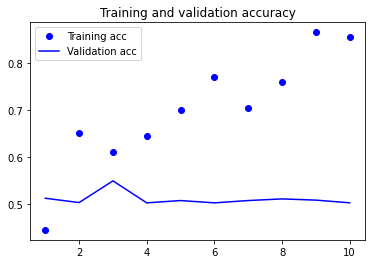

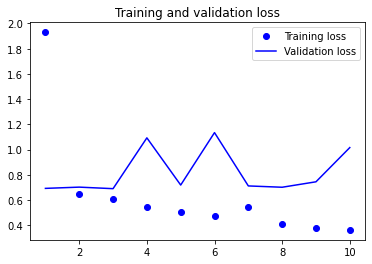

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[과제] 사전 훈련된 임베딩을 사용하지 않고 상기 작업(샘플 200개)을 수행하여 비교해 보세요.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten,Dense

embedding_dim = 200

model = Sequential()
model.add(Embedding(max_words, embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train,y_train,
                    epochs=10,
                    batch_size = 32,
                    validation_data = (x_val,y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 200)          2000000   
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                640032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,640,065
Trainable params: 2,640,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 266ms/step - loss: 0.7032 - acc: 0.4850 - val_loss: 0.6943 - val_acc: 0.5095
Epoch 2/10
7/7 [==============================

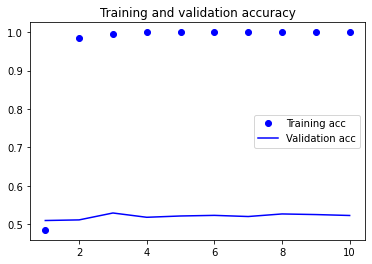

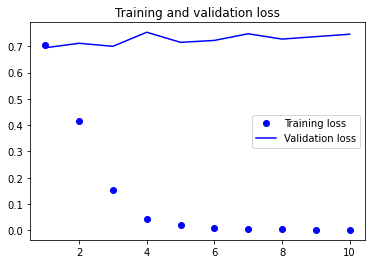

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[과제] 훈련 샘플 수를 2000개로 늘려서 모델링 및 시각화 수행하여 상기 경우와 비교해 보세요.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten,Dense

embedding_dim = 2000

model = Sequential()
model.add(Embedding(max_words, embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train,y_train,
                    epochs=10,
                    batch_size = 32,
                    validation_data = (x_val,y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 2000)         20000000  
                                                                 
 flatten_2 (Flatten)         (None, 200000)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                6400032   
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 26,400,065
Trainable params: 26,400,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 11s 2s/step - loss: 0.8247 - acc: 0.4500 - val_loss: 0.7018 - val_acc: 0.5070
Epoch 2/10
7/7 [==============================

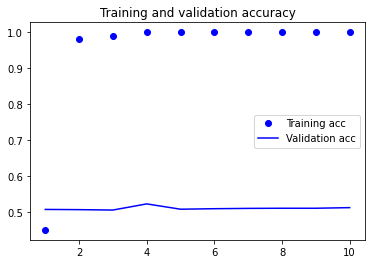

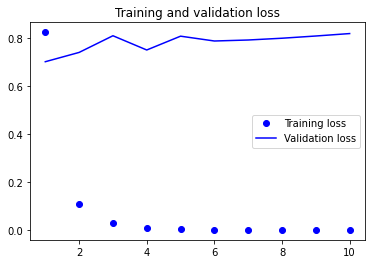

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

https://doc.mindscale.kr/km/unstructured/11.html


[과제] 'https://www.gutenberg.org/files/2591/2591-0.txt' The Project Gutenberg 사이트 텍스트를 전처리 후 다음을 수행하세요.
- 사전 훈련된 Word2Vec을 gensim을 이용하여 임포트 후 cbow, skip-gram 방식으로 모델링하여 유사도 측정
  - wv.similarity('king','prince')
  - wv.most_similar('king')
  - most_similar(positive=['man','princess'], negative=['woman'])
- 옵션 사항
  - size(워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원) : 100
  - window(컨텍스트 윈도우 크기) : 3
  - min_count(단어 최소 빈도 수 제한-빈도가 적은 단어들은 학습하지 않는다.) : 3
  - workers(학습을 위한 프로세스 수) : 4
  - sg = 0은 CBOW, 1은 Skip-gram.


In [23]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove = ('headers','footers', 'quotes'))
documents = dataset.data 
print(len(documents))
documents[3]

11314


'Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it?  ATT\'s last product in this area (a) was priced over\n$1000, as I suspect \'clipper\' phones will be; (b) came to the customer \nwith the key automatically preregistered with government authorities. Thus,\naside from attempting to further legitimize and solidify the fed\'s posture,\nClipper seems to be "more of the same", rather than a new direction.\n   Yes, technology will eventually drive the cost down and thereby promote\nmore widespread use- but at present, the man on the street is not going\nto purchase a $1000 crypto telephone, especially when the guy on the other\nend probably doesn\'t have one anyway.  Am I missing something?\n   The real question is what the gov will do in a year or two when air-\ntight voice privacy on a phone line is as close as your nearest pc.  That\nhas got to a problematic scenario for them, even if the extent of usage\nnever surpasses the \'underground\' stature

In [24]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  d = re.sub(pattern, '', d)
  return d

def clean_stopwords(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w not in stop_words and len(w) > 2])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [25]:
import pandas as pd
news_df = pd.DataFrame({'article':documents})
len(news_df)

11314

In [26]:
news_df.replace("", float('Nan'), inplace=True)
news_df.dropna(inplace=True)
len(news_df)

11096

In [27]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          \nNo arg...
Name: article, Length: 11096, dtype: object

In [28]:
news_df['article'] = news_df['article'].apply(clean_stopwords)
news_df['article']

0        well sure story nad seem biased what disagree ...
1        yeah expect people read faq etc actually accep...
2        although realize principle one strongest point...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system but...
11313    argument murphy scared hell came last year han...
Name: article, Length: 11096, dtype: object

In [29]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()
tokenized_news[168]

['animal', 'rights', 'people', 'know', 'bike', 'riding', 'dogscats', 'racoons']

In [30]:
len(tokenized_news)

11096

In [31]:
import numpy as np
drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_texts = np.delete(tokenized_news, drop_news, axis=0)
print(len(news_texts))

10964


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [32]:
# CBOW

from gensim.models import Word2Vec
model = Word2Vec(sentences = news_texts,
                 window = 4,
                 size = 100,
                 min_count=5,
                 workers=4,
                 sg=0)

In [33]:
model.wv.similarity('man','woman')

0.94302875

In [34]:
model.most_similar(positive=['soldiers'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('azerbaijani', 0.9865351915359497),
 ('turkey', 0.974102795124054),
 ('genocide', 0.9721677899360657),
 ('armenians', 0.9715919494628906),
 ('killed', 0.9686180353164673),
 ('land', 0.9652425646781921),
 ('murdered', 0.964044451713562),
 ('armenia', 0.963628888130188),
 ('lived', 0.9632374048233032),
 ('henrik', 0.9629866480827332)]

In [35]:
model.wv.most_similar(positive=['man','soldiers'], negative=['woman'])

[('son', 0.9886870980262756),
 ('born', 0.9628845453262329),
 ('jewish', 0.956464946269989),
 ('holy', 0.9558915495872498),
 ('jews', 0.9479121565818787),
 ('kingdom', 0.9433655142784119),
 ('church', 0.9419369697570801),
 ('arab', 0.9410006999969482),
 ('history', 0.9409258365631104),
 ('mary', 0.936871349811554)]

[과제] skipgram으로 상기 과제를 수행하세요

In [36]:
model = Word2Vec(sentences = news_texts,
                 window = 4,
                 size = 100,
                 min_count=5,
                 workers=4,
                 sg=1)

In [37]:
model.wv.similarity('man','woman')

0.8185769

In [38]:
model.most_similar(positive=['soldiers'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('wounded', 0.9301508069038391),
 ('girls', 0.9219788312911987),
 ('azeri', 0.9191818237304688),
 ('massacre', 0.9176009297370911),
 ('troops', 0.9142971038818359),
 ('village', 0.9096758961677551),
 ('murdered', 0.9012609720230103),
 ('refugees', 0.9006636738777161),
 ('burned', 0.900192141532898),
 ('fleeing', 0.8996028900146484)]

In [39]:
model.wv.most_similar(positive=['man','soldiers'], negative=['woman'])

[('babies', 0.7661334872245789),
 ('mothers', 0.7608814239501953),
 ('brutally', 0.7430597543716431),
 ('fighters', 0.7427754402160645),
 ('husbands', 0.7411420345306396),
 ('civilians', 0.7411316633224487),
 ('patrol', 0.7411020994186401),
 ('homes', 0.7383716106414795),
 ('greeks', 0.7365835905075073),
 ('massacres', 0.7355057001113892)]